In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Arboles de decisión (*decision trees*)

Método versatil que se puede usar para clasificación y regresión, incluso problemas de *multioutput*.

Los árboles de decisión son los componentes fundamentales para *random forests*, uno de los métodos de *machine learning* más poderosos que existe hoy en día.

#### Entrenamiento y visualización de un árbol de decisión

Volvemos a los datos de los flores "iris".

In [2]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

In [3]:
iris = load_iris()
X = iris.data[:, 2:] #longitud y ancho de los pétalos
y = iris.target

In [4]:
tree_clf = DecisionTreeClassifier(max_depth=2)
tree_clf.fit(X, y)

DecisionTreeClassifier(max_depth=2)

Se puede visualizar el árbol entrenado usando `export_graphviz()` para obtener un archivo de definición de un grafo.

In [6]:
from sklearn.tree import export_graphviz

export_graphviz(tree_clf, out_file="iris_tree.dot",
                feature_names=iris.feature_names[2:], class_names=iris.target_names,
                rounded=True, filled=True)

Se puede convertir el archivo de extensión `.dot` a `.png` usando el paquete `graphviz` ([graphviz](http://www.graphviz.org))

In [7]:
!dot -Tpng iris_tree.dot -o iris_tree.png

![](iris_tree.png)

Ejemplo del uso del árbol:

* Comenzamos en el nodo de raíz (nivel 0): ¿la longitud del pétalo es menor que 2.45cm?
* Si es así, vamos a la izquierda y llegamos a un nodo de hoja y una clasificación (Iris-Setosa)
* Si **no** es así, vamos a la derecha: ¿el ancho del pétalo es menor que o igual a 1.75cm?
* Si la respuesta es "sí", es Iris-Versicolor.
* Si la respuesta es "no", es Iris-Virginica.

Una ventaja de un árbol de decisión es que no requiere mucha preparación de los datos (por ejemplo, *feature scaling*).

Atributos de los nodos:

* `samples`: a cuantas instancias aplica este nodo.
* `value`: a cuantas instancias **en cada clase** aplica este nodo.
* `gini`: una medición de la "impureza" del nodo.

El coeficiente `gini` es 0 si el nodo es "puro" (aplica solamente a instancias de una clase). La definición es

$$G_i = 1 - \sum_{k=1}^n p_{i,k}^2$$

$p_{i,k} = n_k/N_i$ donde 

* $n_k$ es el número de instancias en clase $k$
* $N_i$ es el número de instancias en nodo $i$.

Scikit-Learn ocupa el algoritmo CART que produce árboles binarios: cada nodo puede tener máximo dos hijos. Hay otros algoritmos que permiten más hijos por nodo.

Text(4.05, 0.5, '(Depth=2)')

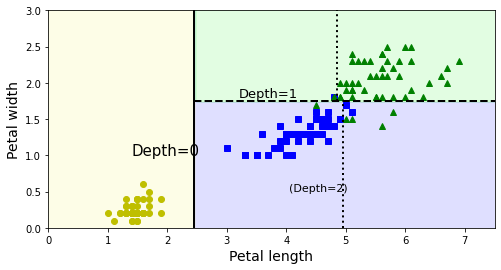

In [13]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[0, 7.5, 0, 3], iris=True, legend=False, plot_training=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if not iris:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    if plot_training:
        plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris setosa")
        plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris versicolor")
        plt.plot(X[:, 0][y==2], X[:, 1][y==2], "g^", label="Iris virginica")
        plt.axis(axes)
    if iris:
        plt.xlabel("Petal length", fontsize=14)
        plt.ylabel("Petal width", fontsize=14)
    else:
        plt.xlabel(r"$x_1$", fontsize=18)
        plt.ylabel(r"$x_2$", fontsize=18, rotation=0)
    if legend:
        plt.legend(loc="lower right", fontsize=14)

plt.figure(figsize=(8, 4))
plot_decision_boundary(tree_clf, X, y)
plt.plot([2.45, 2.45], [0, 3], "k-", linewidth=2)
plt.plot([2.45, 7.5], [1.75, 1.75], "k--", linewidth=2)
plt.plot([4.95, 4.95], [0, 1.75], "k:", linewidth=2)
plt.plot([4.85, 4.85], [1.75, 3], "k:", linewidth=2)
plt.text(1.40, 1.0, "Depth=0", fontsize=15)
plt.text(3.2, 1.80, "Depth=1", fontsize=13)
plt.text(4.05, 0.5, "(Depth=2)", fontsize=11)

Los límites de decisión del árbol.

##### Parentesis: interpretación de modelos

* Se puede interpretar facilmente los resultados de un algoritmo como un árbol de decisión (*white box model*)
* *Random forests* y redes neuronales son mucho más difíciles de interpretar (*black box models*)

#### Estimación de probabilidades de clases

La probabilidad de la clase dada para una instancia: hay que encontrar el nodo de hoja que corresponde a la instancia, después se calcula $p(x) = n_k/N_i$, donde $n_k$ es el número de instancias en la clase $k$ y $N_i$ es el número de instancias en nodo $i$.

Por ejemplo:

* Tenemos una flor con pétalos de longitud $5$cm y ancho $1.5$cm.
* El nodo de hoja que corresponde es el verde.
* Las probabilidades son: Iris-Setosa 0% (0/54), Iris-Versicolor 90.7% (49/54), Iris-Virginica 9.3% (5/54).

In [14]:
tree_clf.predict_proba([[5, 1.5]])

array([[0.        , 0.90740741, 0.09259259]])

In [15]:
tree_clf.predict([[5, 1.5]])

array([1])

### El algoritmo de entrenamiento (*classification and regression tree*, CART)

* El algoritmo divida los datos en dos partes usando un sólo *feature* $k$ y un umbral $t_k$ (por ejemplo, longitud de pétalo $\leq 2.45$cm).
* Encuentra el par $(k, t_k)$ que produce los subconjuntos (ponderados por sus tamaños) más puros.

La función de costo que corresponde es:

$$J(k,t_k) = \frac{m_{\text{izq.}}}{m}G_{\text{izq.}} + \frac{m_{\text{der.}}}{m}G_{\text{der.}}$$

donde $G_{\text{izq.}/\text{der.}}$ es el coeficiente Gini del subconjunto de la izquierda/derecha, y $m_{\text{izq.}/\text{der.}}$ es el número de instancias en el subconjunto de la izquierda/derecha.

Después de dividir los datos en dos partes, repite el proceso con los subconjuntos, y después con los subsubconjuntos, etc. en una manera recursiva.

El algoritmo para cuando llega a la profundidad máxima o cuando no puede encontrar una división que disminuye la impureza.

En Scikit-Learn hay más hiperparámetros para determinar el momento de parar el algoritmo.

Este algoritmo es *greedy* (avaro): busca una división óptima en la primera nivel, y repite el proceso en cada nivel.

No verifica si otra división en el primer nivel implica menor impureza en un nivel más bajo.

Encontrar un árbol óptimo es un problema **NP-completo**: requiere un tiempo de $\mathcal{O}(\exp(m))$.

### Complejidad computacional

* Predicciones: travesar el árbol, de raíz a las hojas, requiere tiempo de $\mathcal{O}(\log_2(m))$ ($m$ es el número de instancias). Predicciones son rápidas.
* Entrenamiento: hay que comparar todos los *features* en todas las instancias en cada nodo. Este requiere tiempo de $\mathcal{O}(n \times m \log(m))$.

### Impureza de Gini o entropía

* La función de costo ocupa, por defecto, el coeficiente Gini.
* Otra opción es la entropía.

La entropía está usada frecuentemente (en *machine learning*) como una medición la impureza de un conjunto de datos: un conjunto tiene entropía cero si las instancias pertenecen a solamente una clase.

La entropía del nodo $i$ se define como:

$$H_i = -\underset{p_{i,k} \neq 0}{\sum_{k=1}^n} p_{i,k} \log_2 (p_{i,k})$$

* El coeficiente Gini tiende a aislar la clase más frecuente en su propia rama del árbol.
* La entropía tiende a producir árboles más balanceados.

### Hiperparámetros de regularización

* Modelos no-paramétricos (como un árbol de decisión): el número de parámetros no se define antes del proceso de entrenamiento. El modelo puede ajustarse muy cercanamente a los datos (*overfitting*)
* Modelos paramétricos (como un modelo lineal): tiene un número pre-determinado de parámetros (menos grados de libertad, menos *overfitting*)

Hiperparámetros para regularizar un árbol de decisión:

* `max_depth`: profundidad máxima del árbol (límite en el número de niveles)
* `min_samples_split`: número mínimo de instancias en un nodo antes de dividir
* `min_samples_leaf`: número mínimo de instancias en un nodo de hoja
* `min_weight_fraction_leaf`: lo mismo, pero expresado como la fracción del número total de instancias ponderadas
* `max_leaf_nodes`: número máximo de nodos de hoja
* `max_features`: número máximo de *features* que están evaluados para división en cada nodo.

Text(0, 0.5, '')

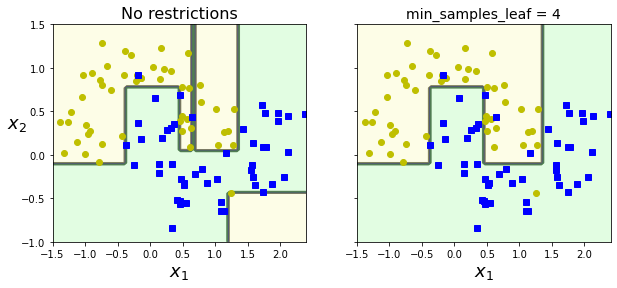

In [18]:
from sklearn.datasets import make_moons
Xm, ym = make_moons(n_samples=100, noise=0.25, random_state=53)

deep_tree_clf1 = DecisionTreeClassifier(random_state=42)
deep_tree_clf2 = DecisionTreeClassifier(min_samples_leaf=4, random_state=42)
deep_tree_clf1.fit(Xm, ym)
deep_tree_clf2.fit(Xm, ym)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(deep_tree_clf1, Xm, ym, axes=[-1.5, 2.4, -1, 1.5], iris=False)
plt.title("No restrictions", fontsize=16)
plt.sca(axes[1])
plot_decision_boundary(deep_tree_clf2, Xm, ym, axes=[-1.5, 2.4, -1, 1.5], iris=False)
plt.title("min_samples_leaf = {}".format(deep_tree_clf2.min_samples_leaf), fontsize=14)
plt.ylabel("")

### Regresión

Se puede implementar regresión con un árbol de decisión también.

In [21]:
np.random.seed(42)
m = 200
X = np.random.rand(m, 1)
y = 4 * (X - 0.5) ** 2
y = y + np.random.randn(m, 1) / 10

In [22]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(max_depth=2)
tree_reg.fit(X, y)

DecisionTreeRegressor(max_depth=2)

In [23]:
export_graphviz(tree_reg, out_file="tree_reg.dot", feature_names=['x1'], 
                rounded=True, filled=True)

In [24]:
!dot -Tpng tree_reg.dot -o tree_reg.png

![](tree_reg.png)

Ahora el árbol predice un valor en cada nodo.

Por ejemplo:

* Tenemos una nueva instancia, $x_1 = 0.6$
* Llegamos al tercer nodo de hoja, con `value=0.111`.

Text(0.5, 1.0, 'max_depth=3')

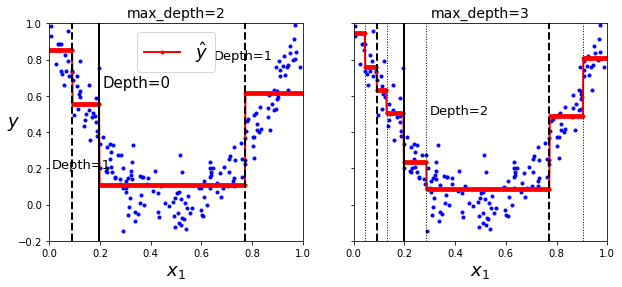

In [25]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(random_state=42, max_depth=2)
tree_reg2 = DecisionTreeRegressor(random_state=42, max_depth=3)
tree_reg1.fit(X, y)
tree_reg2.fit(X, y)

def plot_regression_predictions(tree_reg, X, y, axes=[0, 1, -0.2, 1], ylabel="$y$"):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1$", fontsize=18)
    if ylabel:
        plt.ylabel(ylabel, fontsize=18, rotation=0)
    plt.plot(X, y, "b.")
    plt.plot(x1, y_pred, "r.-", linewidth=2, label=r"$\hat{y}$")

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_regression_predictions(tree_reg1, X, y)
for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
    plt.plot([split, split], [-0.2, 1], style, linewidth=2)
plt.text(0.21, 0.65, "Depth=0", fontsize=15)
plt.text(0.01, 0.2, "Depth=1", fontsize=13)
plt.text(0.65, 0.8, "Depth=1", fontsize=13)
plt.legend(loc="upper center", fontsize=18)
plt.title("max_depth=2", fontsize=14)

plt.sca(axes[1])
plot_regression_predictions(tree_reg2, X, y, ylabel=None)
for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
    plt.plot([split, split], [-0.2, 1], style, linewidth=2)
for split in (0.0458, 0.1298, 0.2873, 0.9040):
    plt.plot([split, split], [-0.2, 1], "k:", linewidth=1)
plt.text(0.3, 0.5, "Depth=2", fontsize=13)
plt.title("max_depth=3", fontsize=14)

El algoritmo CART funcion como antes, aparte de la función de costo. Ahora intentamos minimizar el MSE:

$$J(k,t_k) = \frac{m_{\text{izq.}}}{m}\text{MSE}_{\text{izq.}} + \frac{m_{\text{der.}}}{m}\text{MSE}_{\text{der.}}$$

donde

$$\text{MSE}_{\text{nodo}} = \sum_{i \in \text{nodo}} \left( \hat{y}_{\text{nodo}} - y^{(i)} \right)^2 \quad \quad \hat{y}_{\text{nodo}} = \frac{1}{m_{\text{nodo}}} \sum_{i \in \text{nodo}} y^{(i)}$$

Ya que por defecto no hay restricción en el árbol, hay que tener cuidado con *overfitting*.

![](figures_arboles/fig6-6.png)

### Inestabilidad

Hay limitaciones con árboles de decisión: todos los límites de decisión son ortogonales a los ejes del espacio de parámetros. Por eso, están sensibles a rotaciones del conjunto de datos.

| ![](figures_arboles/fig6-7.png) |
|---------------------------------|
| Izquierda: datos linealmente separables. Derecha: los mismos datos después de una rotación. |

Una opción para resolver este problema es el uso de PCA (un algoritmo sin supervisión que veremos más tarde) para transformar los datos.

El problema principal con árboles de decisión es que son muy sensibles a cambios menores en los datos.

Por ejemplo, si sacamos la Iris-Versicolor más ancha de los datos de "iris", el árbol de decisión que puede resultar es:

![](figures_arboles/fig6-8.png)

De hecho, el algoritmo de entrenamiento de Scikit-Learn es **estocástico** (elige **aleatoriamente** el conjunto de *features* evaluados en cada nodo).

Así que es posible tener distintos árboles en el mismo conjunto de datos cada vez que entrenamos el modelo (se puede eliminar esta variabilidad con el parámetro `random_state`)

El algoritmo *random forest* reduce esta inestabilidad por promediar muchos árboles.